In [8]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from physics import JT_GMS, SMT
from constants import *
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from exp_setup import Cylindrical_Grid, Experiment
from TTM_solver import TwoTemperatureModel

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

# Argon Profile Data
 
Based on 
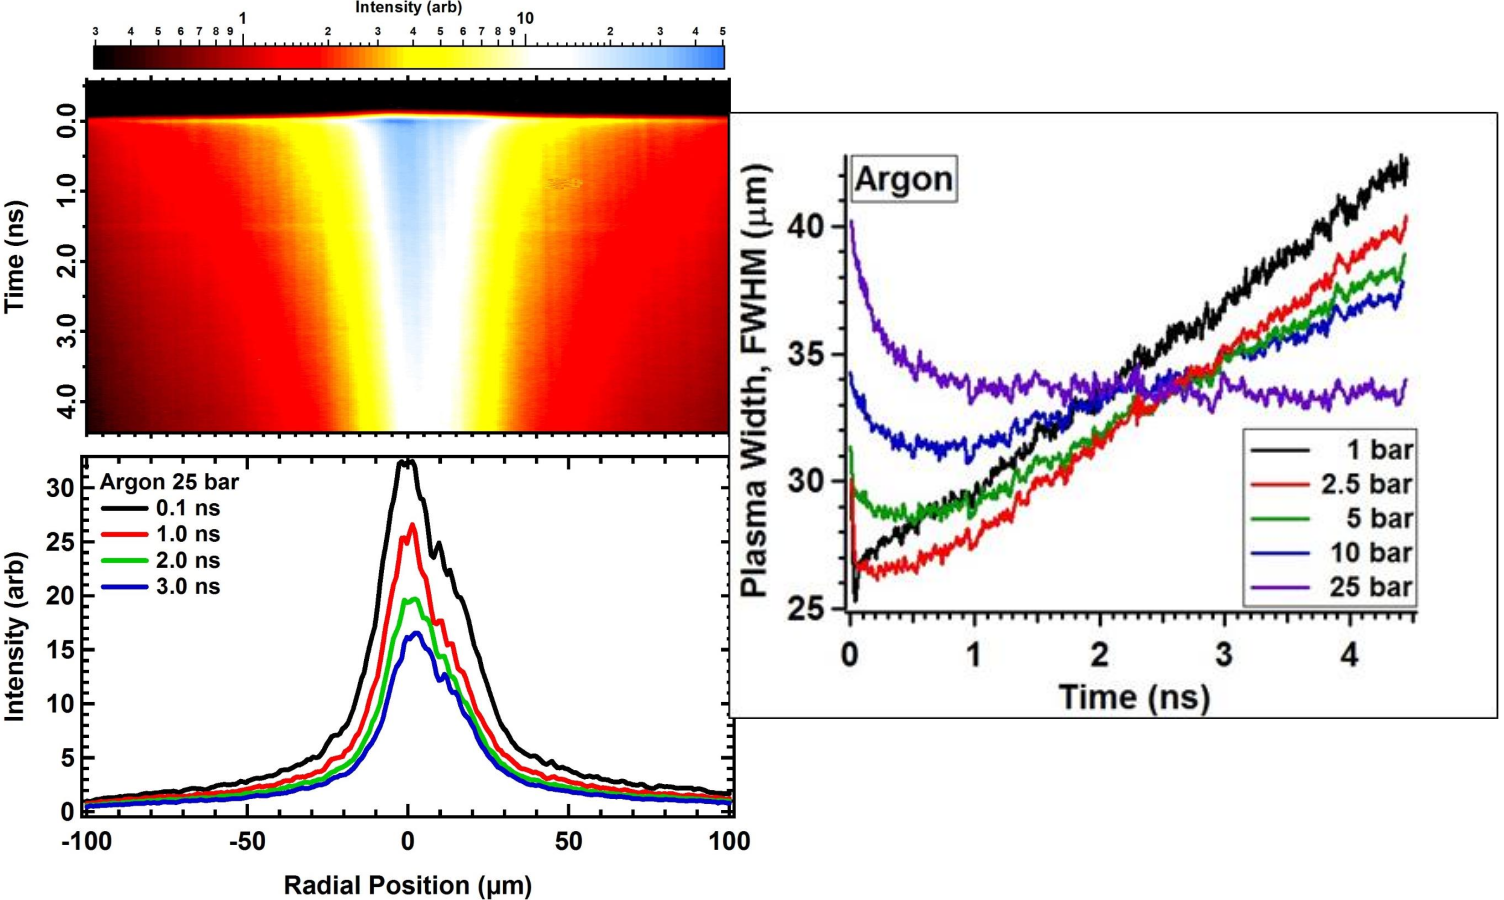

<div>
<img src="attachment:Argon_Profile_Exp_Data_all3.png" width="500"/>
</div>

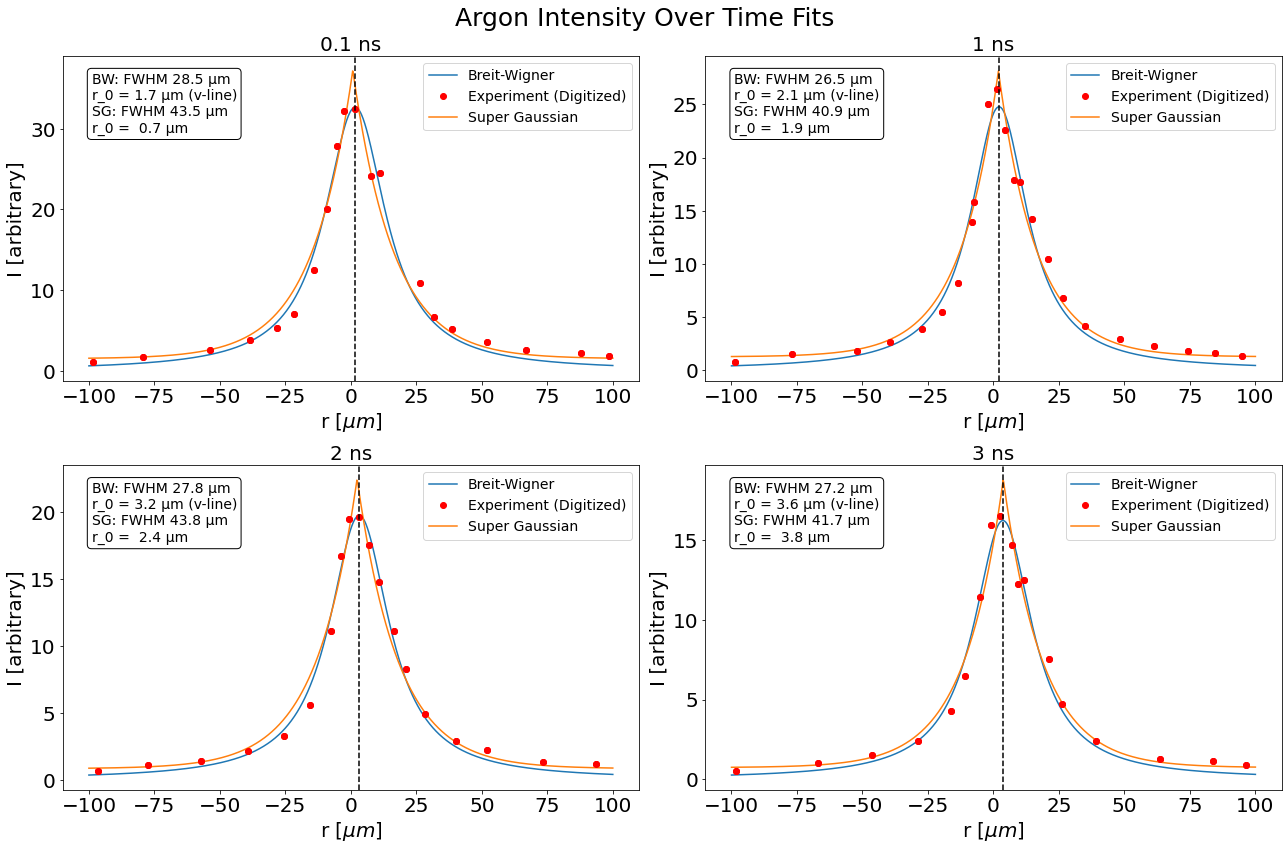

In [9]:
I_0p1ns_file = "./data/experimental_data/Ar_25bar_Te_Profile_0.1ns.txt"
I_1ns_file = "./data/experimental_data/Ar_25bar_Te_Profile_1ns.txt"
I_2ns_file = "./data/experimental_data/Ar_25bar_Te_Profile_2ns.txt"
I_3ns_file = "./data/experimental_data/Ar_25bar_Te_Profile_3ns.txt"

from scipy.optimize import curve_fit

class I_Fit():
    def __init__(self, file):
        self.file = file
        self.data = read_csv(file, delim_whitespace=True, header=1)
        self.r_data, self.I_data = self.data['r[μm]'], self.data['I[NA]']
        
        self.get_fit()
        
        
    def get_fit(self):
        self.fit_vals = curve_fit(self.fit_func, self.r_data, self.I_data, p0=self.fit_guess, maxfev=int(1e4))[0]
        self.r_array = np.linspace(-100,100,num=1000)
        self.I_array = self.fit_func(self.r_array, *self.fit_vals)
        
    def show_fit_plot(self, show=False):
        fig, ax = plt.subplots()
        self.make_plot(ax)
        plt.show()
    
    def make_plot(self, ax):
        ax.plot(self.r_array, self.I_array, label=self.name)
        ax.plot(self.r_data, self.I_data, 'ro', label='Experiment (Digitized)')
        ax.set_xlabel('r [$\mu m$]', fontsize=20)
        ax.set_ylabel('I [arbitrary]', fontsize=20)
        
    def make_T_array(self, emissivity):
        self.emissivity = emissivity
        self.T_array = (self.I_array/emissivity)**.25
        self.T_data  = (self.I_data/emissivity)**.25
        
class Gaussian_I_Fit(I_Fit):
    def __init__(self, file):
        self.fit_guess = [1,37, 1, 1]
        super().__init__(file)
        self.name = 'Gaussian'
        self.txt  = 'G: FWHM {0:.1f} μm\nr_0 =  {1:.1f} μm'.format(
            np.abs(self.fit_vals[1]), self.fit_vals[3])
        
    @staticmethod
    def fit_func(r_μm, I_max, FWHM, I_0, r0): # P for super gaussian
        P = 2
        return I_0 + I_max * np.exp(-np.log(2)* ( 4*np.abs(r_μm-r0)/FWHM)**P  )

class Super_Gaussian_I_Fit(I_Fit):
    def __init__(self, file):
        self.fit_guess = [1,37, 1, 1]
        super().__init__(file)
        self.name = 'Super Gaussian'
        self.txt  = 'SG: FWHM {0:.1f} μm\nr_0 =  {1:.1f} μm'.format(
            np.abs(self.fit_vals[1]), self.fit_vals[3])
        
    @staticmethod
    def fit_func(r_μm, I_max, FWHM, I_0, r0): # P for super gaussian
        P = 1
        return I_0 + I_max * np.exp(-np.log(2)* ( 4*np.abs(r_μm-r0)/FWHM)**P  )

class BreitWigner_I_Fit(I_Fit): #Lorntz, Cauchy, etc.
    def __init__(self, file):
        self.fit_guess = [1, 37, 1]
        super().__init__(file)
        self.name = 'Breit-Wigner' 
        self.txt  = 'BW: FWHM {0:.1f} μm \nr_0 = {1:.1f} μm (v-line)'.format(np.abs(self.fit_vals[1]), self.fit_vals[2])
        
    @staticmethod
    def fit_func(r_μm, I_max, FWHM, r0):
        # When r = Γ, we have I_max/2, so FHWM = 2 Γ 
        Γ = FWHM/2
        return I_max*Γ**2 / ( np.abs(r_μm-r0)**2 + Γ**2 )

files = [I_0p1ns_file, I_1ns_file, I_2ns_file, I_3ns_file]
titles= ["0.1 ns", "1 ns", "2 ns", "3 ns"]
# for title, file in zip(titles, files):

fig, axs = plt.subplots(2,2, figsize=(18,12))
fig.suptitle("Argon Intensity Over Time Fits", fontsize=25)
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        indx = i*2+j
        file=files[indx]
        title=titles[indx]
        
        ax.set_title(title, fontsize=20)
        
        I_fit_BW = BreitWigner_I_Fit(file)
#         I_fit_G  = Gaussian_I_Fit(file)
        I_fit_SG = Super_Gaussian_I_Fit(file)

        I_fit_BW.make_plot(ax)
#         I_fit_G.make_plot(ax)
        I_fit_SG.make_plot(ax)

        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), fontsize=14)

        props = dict(boxstyle='round', facecolor='white')

        # place a text box in upper left in axes coords
        ax.text(0.05, 0.95, I_fit_BW.txt + '\n' + I_fit_SG.txt, transform=ax.transAxes, fontsize=14,
                verticalalignment='top', bbox=props)
        ax.axvline(x=I_fit_BW.fit_vals[-1],linestyle='--', color='k')

        ax.tick_params(labelsize=20)
    plt.tight_layout()
plt.show()


In [10]:
I_fits = []
emissivity_list = [1.0339285714285713, 1.0285714285714285, 0.8875, 0.7678571428571428]
for ε, file in zip(emissivity_list, files):
    I_fits.append(BreitWigner_I_Fit(file))
#     I_fits.append(Super_Gaussian_I_Fit(file))
    I_fits[-1].make_T_array(ε)

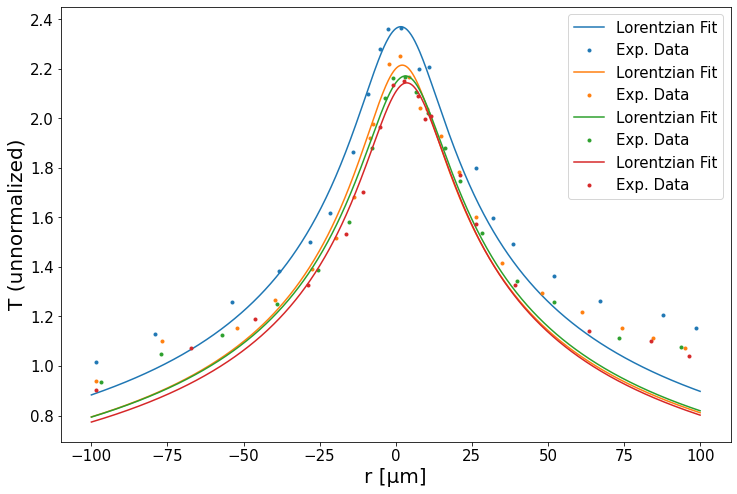

In [91]:
fig, ax = plt.subplots(figsize = (12,8), facecolor='white')

for k, I_fit in enumerate(I_fits):
    color = colors[k]#plt.cm.jet(k/4) 
    ax.plot(I_fit.r_array, I_fit.T_array, color=color, label='Lorentzian Fit')
    ax.plot(I_fit.r_data, I_fit.T_data, marker='.', linestyle='',color=color, label= 'Exp. Data')

ax.set_ylabel("T (unnormalized)", fontsize=20)
ax.set_xlabel("r [μm]",fontsize=20)
ax.legend(fontsize=15)
ax.tick_params(labelsize=15)

# Ionization Rates

See [Mansbach & Keck](https://doi.org/10.1103/PhysRev.181.275) and the recent modification in [Pohl et al.](http://dx.doi.org/10.1103/PhysRevLett.100.223201) 


In [39]:
T0_profile = I_fits[0].T_array*1e4* K_to_eV
ne_cc = 6e20
ionization_relaxation_rate = 2e-27 * ne_cc * T0_profile**(-4.5)


In [50]:
α = 1/137
eV_to_Hartree = 0.0367493 
AU_to_s = 2.418884254e-17
ne_AU = ne_cc * a_B**3
T_AU = T0_profile * K_to_eV * eV_to_Hartree

n_Argon = 3 # Principal number for excitation???
# Aγ_AU = α**3 * n_Argon**-4.5
# An_AU =7*ne_AU /T_AU**.17 * n_Argon**2.66
# 1/Aγ_AU*AU_to_s, 1/An_AU*AU_to_s

(8.726145198552918e-09,
 array([2.32007848e-10, 2.32045979e-10, 2.32084189e-10, 2.32122477e-10,
        2.32160845e-10, 2.32199292e-10, 2.32237819e-10, 2.32276427e-10,
        2.32315115e-10, 2.32353884e-10, 2.32392734e-10, 2.32431666e-10,
        2.32470679e-10, 2.32509775e-10, 2.32548953e-10, 2.32588214e-10,
        2.32627558e-10, 2.32666986e-10, 2.32706497e-10, 2.32746093e-10,
        2.32785773e-10, 2.32825538e-10, 2.32865388e-10, 2.32905323e-10,
        2.32945345e-10, 2.32985452e-10, 2.33025646e-10, 2.33065927e-10,
        2.33106296e-10, 2.33146751e-10, 2.33187295e-10, 2.33227928e-10,
        2.33268649e-10, 2.33309458e-10, 2.33350358e-10, 2.33391347e-10,
        2.33432426e-10, 2.33473596e-10, 2.33514857e-10, 2.33556209e-10,
        2.33597653e-10, 2.33639189e-10, 2.33680817e-10, 2.33722538e-10,
        2.33764353e-10, 2.33806261e-10, 2.33848263e-10, 2.33890359e-10,
        2.33932550e-10, 2.33974837e-10, 2.34017218e-10, 2.34059696e-10,
        2.34102271e-10, 2.34144942e-10, 

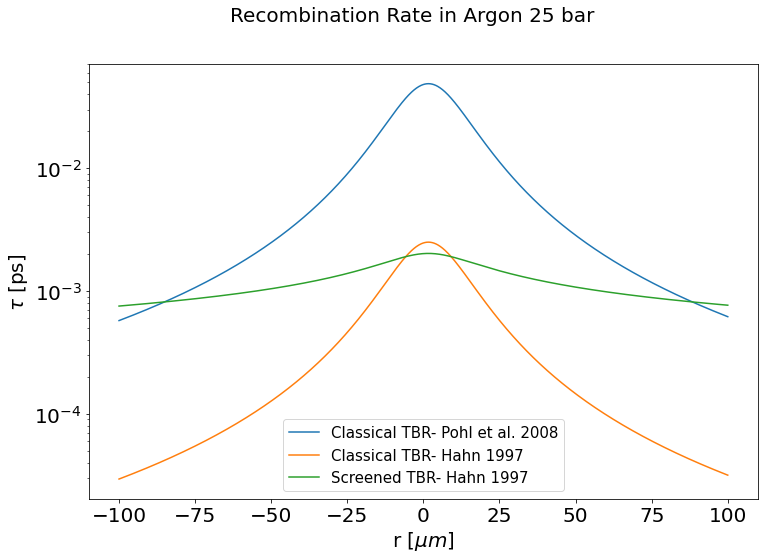

In [89]:
T_K = T0_profile /K_to_eV# * eV_to_Hartree
α_recomb = 2.77e-9*(T_K)**-4.5
τ_recomb_Pohl2008 = 1/(α_recomb * ne_cc**2)


α_recomb = 1.1e-31 * Z**3*Γzn*(T_Ry)**-4.5
τ_recomb_Hahn1997_classical = 1/(α_recomb * ne_cc**2)

Γzn = 2
Z=1
ni_cc = ne_cc/Z
T_Ry = T0_profile * eV_to_Hartree*2
τ_recomb_Hahn = 1/(1.8e-4 * (T_Ry)**-1*ne_cc**(5/6)*Γzn*Z**-4)


fig, ax = plt.subplots(figsize = (12,8), facecolor='white')
fig.suptitle("Recombination Rate in Argon 25 bar", fontsize=20)
# ax.plot(I_fits[0].r_array, 1/An_AU*AU_to_s*1e9, label="Collisional De-excitation")
# ax.plot(I_fits[0].r_array, 1/Aγ_AU*AU_to_s*np.ones_like(I_fits[0].r_array)*1e9, label="Radiative De-excitation")
ax.plot(I_fits[0].r_array, τ_recomb_Pohl2008*1e12, label='Classical TBR- Pohl et al. 2008')
ax.plot(I_fits[0].r_array, τ_recomb_Hahn1997_classical*1e12, label='Classical TBR- Hahn 1997')
ax.plot(I_fits[0].r_array, τ_recomb_Hahn*1e12, label='Screened TBR- Hahn 1997')
ax.set_ylabel(r"$\tau$ [ps]", fontsize=20)
ax.set_xlabel(r"r [$\mu m$]", fontsize = 20)
ax.tick_params(labelsize=20)
ax.set_yscale('log')
ax.legend(fontsize=15)